In [22]:
import tensorflow as tf
from tensorflow import keras as k
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import typing

tf.keras.utils.set_random_seed(42) # sets the Python, NumPy and TensorFlow seed
tf.config.experimental.enable_op_determinism() # forces threads to work in deterministic way

# test_examples=3669, train_examples=3680, total=7349;
(train_ds, val_ds, test_ds), info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, as_supervised=True, split=['train+test[:40%]', 'test[40%:70%]', 'test[70%:]'])

# Calculate the number of classes i.e.37
num_classes = info.features['label'].num_classes


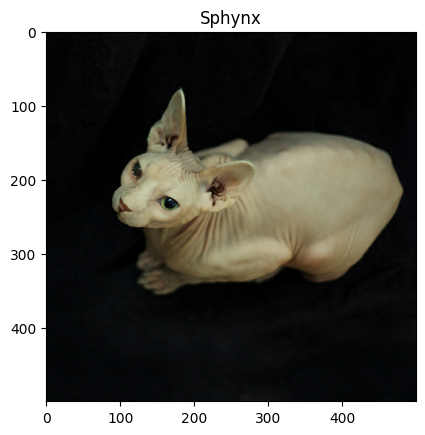

In [2]:
get_label_name = info.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title( get_label_name( label ) )


In [4]:
test_ds
tfds.show_examples(test_ds, info, rows=4, cols=4, image_key='image')

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def resize_256_ohc(img, label):
    image = tf.image.resize(img, (256, 256))
    return image, tf.one_hot( label, depth=num_classes )

def resize_227(img, label):
    image = tf.image.resize(img, (227, 227))
    return image, label

def norm(img, label):
    image = image /225.0
    return image, label

def hor_flip(img, label):
    image = tf.image.flip_left_right(img)
    return image, label

def ver_flip(img, label):
    image = tf.image.flip_up_down(img)
    return image, label

def rot90(img, label):
    image = tf.image.rot90(img)
    return image, label

def bright(img, label):
    image = tf.image.adjust_brightness(img, 0.4)
    return image, label

def saturated(img, label):
    image = tf.image.adjust_saturation(img, 3)
    return image, label

pre = train_ds.map(resize_256_ohc, num_parallel_calls=AUTOTUNE)


pre_org = train_ds.map(resize_227, num_parallel_calls=AUTOTUNE)
# List of transformation functions on 227 image size
transformations = [hor_flip, ver_flip, rot90, bright]
final_dataset = pre_org
for transform in transformations:
    transformed_dataset = pre_org.map(transform)
    final_dataset = final_dataset.concatenate(transformed_dataset)
    if transform == hor_flip:
        pre_saturated = transformed_dataset.map(saturated, num_parallel_calls=AUTOTUNE)
        final_dataset = final_dataset.concatenate(pre_saturated)


def crop(img, label):
    image = tf.image.central_crop(img, central_fraction=0.85)
    image = tf.image.resize(image, (227, 227))
    return image, label
pre_crop = pre.map(crop, num_parallel_calls=AUTOTUNE)

def top_left_crop(img, label):
  corner_size = 227
  return img[:corner_size, :corner_size, :], label

def top_right_crop(img, label):
  corner_size = 227
  width = 256    # height, width, _ = image.shape
  return img[:corner_size, width-corner_size:, :], label

def bottom_left_crop(img, label):
  corner_size = 227
  height = 256    # height, width, _ = image.shape
  return img[height-corner_size:, :corner_size, :], label

def bottom_right_crop(img, label):
  corner_size = 227
  height = 256; width = 256   # height, width, _ = image.shape
  return img[height-corner_size:, width-corner_size:, :], label

# List of transformation functions on 256 size image
transformations = [crop, top_left_crop, top_right_crop, bottom_left_crop, bottom_right_crop]
for transform in transformations:
    transformed_dataset = pre_org.map(transform)
    final_dataset = final_dataset.concatenate(transformed_dataset)

train_ds = final_dataset.map(norm, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size=len(train_ds),seed=42).batch(BATCH_SIZE, deterministic=True, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
def val_pre(img, label):
    image = tf.image.resize(img, (227, 227))
    image = image /225.0
    return image, tf.one_hot( label, depth=num_classes )
val_ds = val_ds.map(val_pre, num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE, deterministic=True, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(val_pre, num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE, deterministic=True, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)


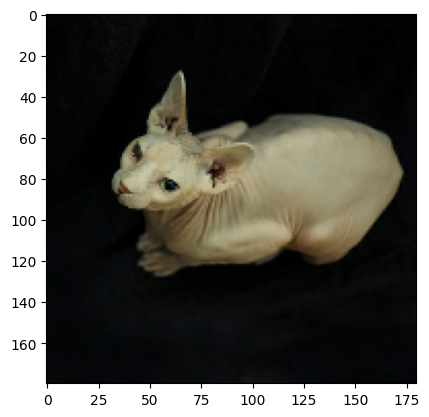

In [ ]:
IMG_SIZE = 180

resize_and_rescale = k.Sequential([
  k.layers.Resizing(IMG_SIZE, IMG_SIZE),
  k.layers.Rescaling(1./255)
])

result = resize_and_rescale(image)
_ = plt.imshow(result)

In [ ]:
data_augmentation = k.Sequential([
  k.layers.RandomFlip("horizontal_and_vertical"),
  k.layers.RandomRotation(0.2),
])
print(image.shape)
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
print(image.shape)

(500, 500, 3)
(1, 500, 500, 3)


In [ ]:
# prompt: find image array max and min numbers

print(tf.math.reduce_max(image).numpy())
print(tf.math.reduce_min(image).numpy())


255.0
0.0


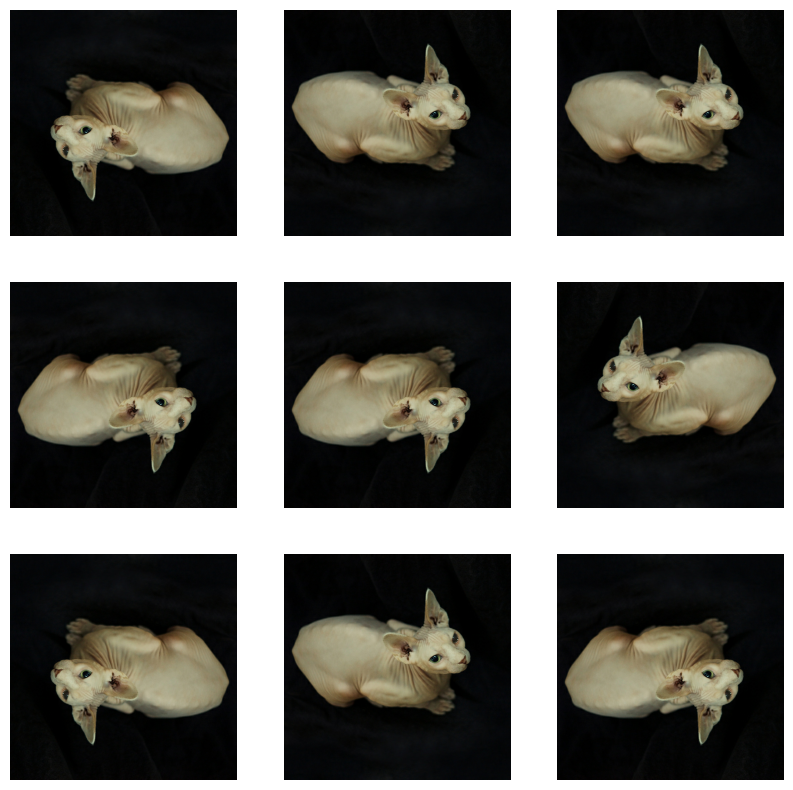

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  # print(image[0][:,:,1])
  # print(augmented_image[0][:,:,1])
  # print(tf.math.reduce_max(augmented_image[0]).numpy())
  # print(tf.math.reduce_min(augmented_image[0]).numpy())
  # break
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(tf.cast(augmented_image[0],dtype=tf.uint8))
  plt.axis("off")


In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)
  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [ ]:
tf.image.flip_up_down

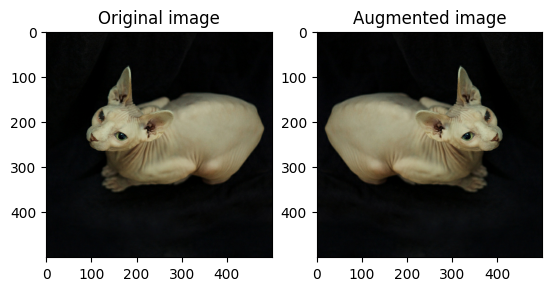

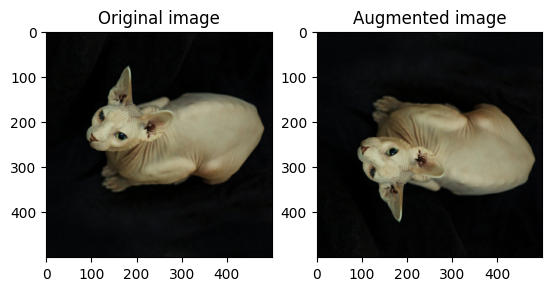

In [ ]:
hor_flipped = tf.image.flip_left_right(image)
ver_flipped = tf.image.flip_up_down(image)
visualize(image, hor_flipped)
visualize(image, ver_flipped)

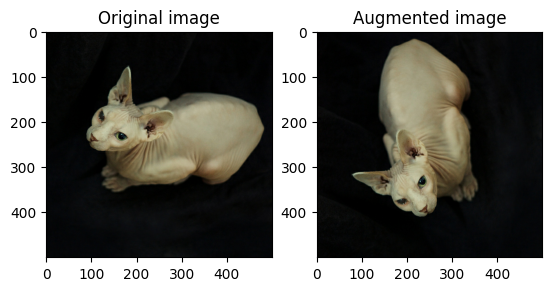

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

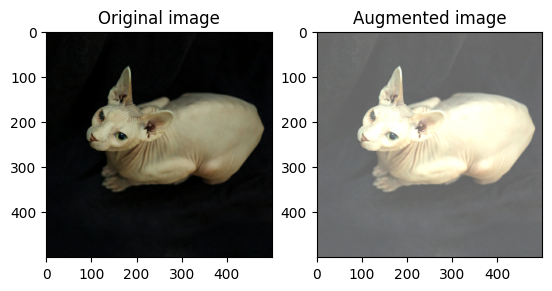

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

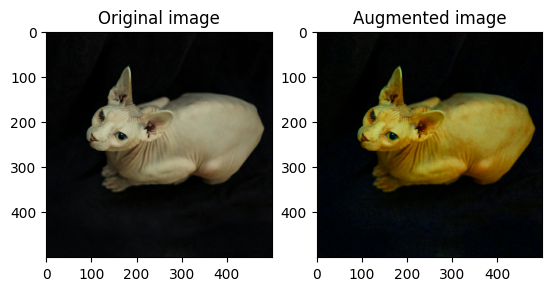

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

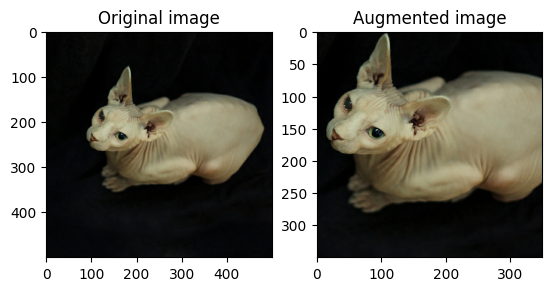

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.85)
visualize(image,cropped)

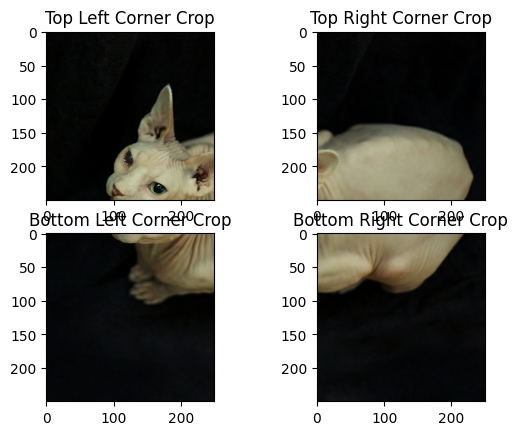

In [ ]:
# prompt: how to crop corners of image in tensorflow for data augmentation

# There's no built-in function for corner cropping in TensorFlow.
# Here's how you can achieve a similar effect using slicing:

def crop_corners(image, corner_size):
  height, width, _ = image.shape
  top_left_crop = image[:corner_size, :corner_size, :]
  top_right_crop = image[:corner_size, width-corner_size:, :]
  bottom_left_crop = image[height-corner_size:, :corner_size, :]
  bottom_right_crop = image[height-corner_size:, width-corner_size:, :]
  return top_left_crop, top_right_crop, bottom_left_crop, bottom_right_crop

# Example usage:
corner_size = 250
top_left, top_right, bottom_left, bottom_right = crop_corners(image.numpy(), corner_size)

# Visualize the cropped corners (example for top_left)

fig = plt.figure()
plt.subplot(2,2,1)
plt.title("Top Left Corner Crop")
plt.imshow(top_left)
plt.subplot(2,2,2)
plt.title('Top Right Corner Crop')
plt.imshow(top_right)
plt.subplot(2,2,3)
plt.title('Bottom Left Corner Crop')
plt.imshow(bottom_left)
plt.subplot(2,2,4)
plt.title('Bottom Right Corner Crop')
plt.imshow(bottom_right)

# Note: This crops fixed-size corners. For random corner cropping during augmentation,
# you'd need to integrate this into your data augmentation pipeline and randomize the corner_size.


In [ ]:
# Shuffle the combined dataset
# dataset = dataset.shuffle(buffer_size=num_examples, seed=42)

def preprocess(ds):
    image = tf.image.resize(ds['image'], (IMAGE, IMAGE))
    image = image / 255.0
    return image,tf.one_hot( ds['label'], depth=num_classes )

IMAGE=256
BATCH_SIZE = 512

train_data = train_dataset.map(preprocess).batch(BATCH_SIZE,deterministic=True,num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_dataset.map(preprocess).batch(BATCH_SIZE,deterministic=True,num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE,deterministic=True,num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
def alex_net_org(input_shape: typing.Tuple[int], classes: int = 37) -> k.Model:
    k.utils.set_random_seed(42)
    alexnet = k.Sequential([
        k.layers.Input(shape=input_shape),
        k.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu',
                        kernel_initializer=k.initializers.GlorotUniform(), bias_initializer='zeros'),
        k.layers.BatchNormalization(),
        k.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        k.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu',
                        kernel_initializer=k.initializers.GlorotUniform(), bias_initializer='zeros'),
        k.layers.BatchNormalization(),
        k.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        k.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                        kernel_initializer=k.initializers.GlorotUniform(), bias_initializer='zeros'),
        k.layers.BatchNormalization(),
        k.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                        kernel_initializer=k.initializers.GlorotUniform(), bias_initializer='zeros'),
        k.layers.BatchNormalization(),

        k.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                        kernel_initializer=k.initializers.GlorotUniform(), bias_initializer='zeros'),
        k.layers.BatchNormalization(),

        k.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        k.layers.Flatten(),

        k.layers.Dense(units=4096, activation='relu', kernel_initializer=k.initializers.HeUniform(), bias_initializer='zeros'),
        k.layers.Dropout(0.5),
        k.layers.BatchNormalization(),

        k.layers.Dense(units=4096, activation='relu', kernel_initializer=k.initializers.HeUniform(), bias_initializer='zeros'),
        k.layers.Dropout(0.5),
    ])
    alexnet.add(k.layers.Dense(units=classes, activation='softmax', kernel_initializer=k.initializers.GlorotUniform(), bias_initializer='zeros'))
    return alexnet
alex_net_model = alex_net_org((IMAGE, IMAGE, 3), num_classes)
alex_net_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 62, 62, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 30, 30, 256)       1024      
 chNormalization)                                                
                                                        

In [ ]:
alex_net_model.compile(
        optimizer=k.optimizers.Adam(learning_rate=0.001, weight_decay=0.5),
        loss=k.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size'),
        metrics=[k.metrics.CategoricalAccuracy()],
    )

hist = alex_net_model.fit(train_data, epochs=20, shuffle=False, validation_data=val_data, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=8)])

Epoch 1/20
9/9 [==============================] - 47s 4s/step - loss: 6.8952 - categorical_accuracy: 0.0324 - val_loss: 3.6251 - val_categorical_accuracy: 0.0279
Epoch 2/20
9/9 [==============================] - 9s 963ms/step - loss: 3.6509 - categorical_accuracy: 0.0288 - val_loss: 3.6134 - val_categorical_accuracy: 0.0327
Epoch 3/20
9/9 [==============================] - 9s 972ms/step - loss: 3.6150 - categorical_accuracy: 0.0272 - val_loss: 3.6129 - val_categorical_accuracy: 0.0327
Epoch 4/20
9/9 [==============================] - 9s 1s/step - loss: 3.6092 - categorical_accuracy: 0.0279 - val_loss: 3.6119 - val_categorical_accuracy: 0.0211
Epoch 5/20
9/9 [==============================] - 9s 985ms/step - loss: 3.6104 - categorical_accuracy: 0.0272 - val_loss: 3.6117 - val_categorical_accuracy: 0.0231
Epoch 6/20
9/9 [==============================] - 9s 980ms/step - loss: 3.6093 - categorical_accuracy: 0.0356 - val_loss: 3.6114 - val_categorical_accuracy: 0.0272
Epoch 7/20
9/9 [=====

In [ ]:
hist1 = alex_net_model.fit(train_data, epochs=20, shuffle=False, validation_data=val_data, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=8)])

Epoch 1/20
9/9 [==============================] - 9s 982ms/step - loss: 3.5915 - categorical_accuracy: 0.0352 - val_loss: 3.6052 - val_categorical_accuracy: 0.0436
Epoch 2/20
9/9 [==============================] - 9s 1s/step - loss: 3.5881 - categorical_accuracy: 0.0386 - val_loss: 3.6047 - val_categorical_accuracy: 0.0463
Epoch 3/20
9/9 [==============================] - 9s 974ms/step - loss: 3.5864 - categorical_accuracy: 0.0454 - val_loss: 3.6033 - val_categorical_accuracy: 0.0408
Epoch 4/20
9/9 [==============================] - 9s 990ms/step - loss: 3.5853 - categorical_accuracy: 0.0458 - val_loss: 3.5986 - val_categorical_accuracy: 0.0538
Epoch 5/20
9/9 [==============================] - 9s 1s/step - loss: 3.5819 - categorical_accuracy: 0.0474 - val_loss: 3.5950 - val_categorical_accuracy: 0.0456
Epoch 6/20
9/9 [==============================] - 9s 1s/step - loss: 3.5809 - categorical_accuracy: 0.0456 - val_loss: 3.5983 - val_categorical_accuracy: 0.0436
Epoch 7/20
9/9 [=========

In [ ]:
hist3 = alex_net_model.fit(train_data, epochs=20, shuffle=False, validation_data=val_data, verbose=1, callbacks=[k.callbacks.EarlyStopping(patience=8)])

Epoch 1/20
9/9 [==============================] - 9s 1s/step - loss: 3.4683 - categorical_accuracy: 0.0646 - val_loss: 3.4765 - val_categorical_accuracy: 0.0572
Epoch 2/20
9/9 [==============================] - 9s 960ms/step - loss: 3.4600 - categorical_accuracy: 0.0683 - val_loss: 3.4918 - val_categorical_accuracy: 0.0545
Epoch 3/20
9/9 [==============================] - 9s 971ms/step - loss: 3.4425 - categorical_accuracy: 0.0744 - val_loss: 3.4710 - val_categorical_accuracy: 0.0565
Epoch 4/20
9/9 [==============================] - 9s 984ms/step - loss: 3.4429 - categorical_accuracy: 0.0653 - val_loss: 3.5069 - val_categorical_accuracy: 0.0545
Epoch 5/20
9/9 [==============================] - 9s 991ms/step - loss: 3.4314 - categorical_accuracy: 0.0739 - val_loss: 3.4913 - val_categorical_accuracy: 0.0579
Epoch 6/20
9/9 [==============================] - 9s 981ms/step - loss: 3.4195 - categorical_accuracy: 0.0721 - val_loss: 3.4452 - val_categorical_accuracy: 0.0626
Epoch 7/20
9/9 [===